In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Bước 1: Đọc dữ liệu từ file CSV
data = pd.read_csv('creditcard.csv')

# Kiểm tra nhãn gian lận
print(data['Class'].value_counts())  # Kiểm tra phân phối của nhãn Class (0 = bình thường, 1 = gian lận)

# Bước 2: Tách đặc trưng và nhãn
X = data.drop(columns=['Class'])  # Đặc trưng
y = data['Class']  # Nhãn dữ liệu đã được gán sẵn

# Bước 3: Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# # Sử dụng SMOTE để cân bằng dữ liệu
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Sau đó chia dữ liệu cân bằng thành tập huấn luyện và kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Bước 4: Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước dữ liệu
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Class
0    284315
1       492
Name: count, dtype: int64
Train size: 227845, Test size: 56962


In [2]:
# Bước 5: Khởi tạo Isolation Forest với tham số điều chỉnh
iso_forest = IsolationForest(n_estimators=200, contamination=0.002, random_state=42)

# Bước 6: Huấn luyện mô hình trên dữ liệu huấn luyện
iso_forest.fit(X_train)

# Bước 7: Dự đoán trên tập kiểm tra
y_pred_test = iso_forest.predict(X_test)

# Isolation Forest trả về -1 cho bất thường và 1 cho bình thường, do đó cần chuyển đổi nhãn
y_pred_test = np.where(y_pred_test == -1, 1, 0)  # 1 là bất thường (gian lận), 0 là bình thường

# Bước 8: Tính toán điểm bất thường (anomaly scores)
anomaly_scores = iso_forest.decision_function(X_test)


In [3]:
# Bước 9: Điều chỉnh ngưỡng phát hiện bất thường (chọn ngưỡng dựa trên phân vị thứ 5)
threshold = np.percentile(anomaly_scores, 5)  # 5% điểm thấp nhất có thể là bất thường

# Dự đoán lại dựa trên ngưỡng mới
y_pred_test_adjusted = (anomaly_scores < threshold).astype(int)

In [4]:
# Bước 10: Đánh giá mô hình bằng confusion matrix, classification report và ROC AUC
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_test_adjusted))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_test_adjusted))


Confusion Matrix:
 [[54098  2766]
 [   15    83]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.85      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962

ROC AUC Score: 0.899148200360617


    anomaly_score  predicted_anomaly  actual_label
0       -0.077109                  1             1
9        0.150283                  1             0
15       0.156317                  1             0
31       0.150852                  1             0
32      -0.073316                  1             0


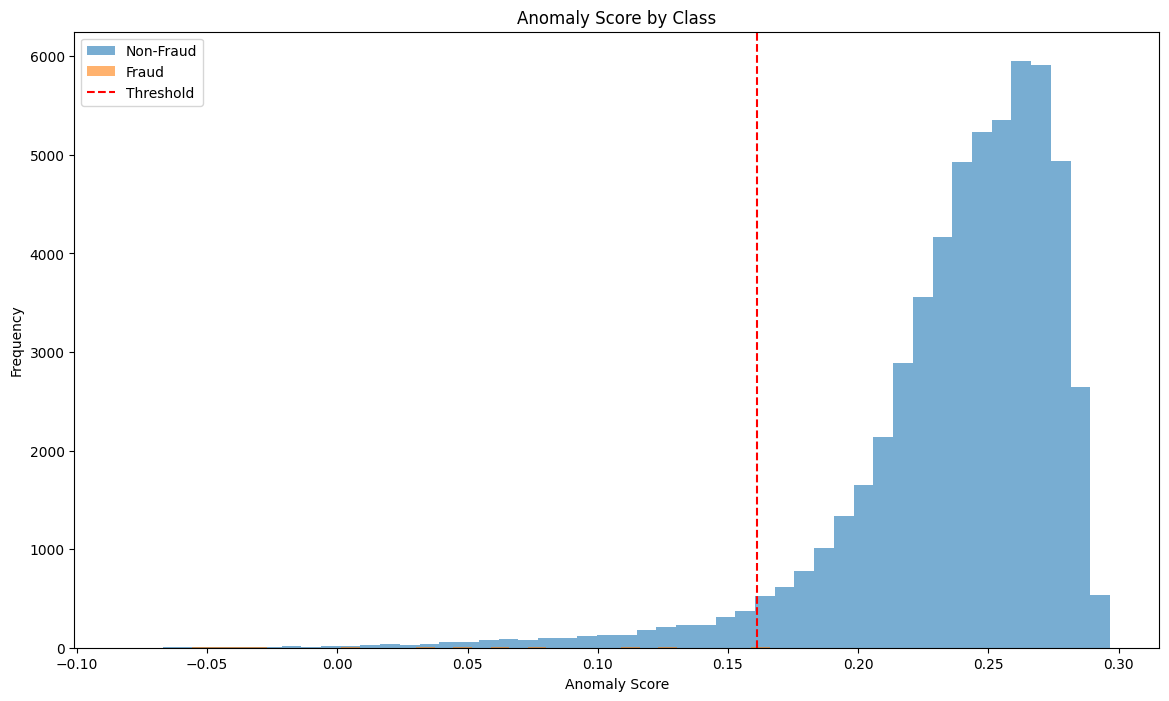

In [5]:
# Bước 11: Hiển thị các giao dịch mà mô hình đánh dấu là gian lận và so sánh với nhãn thực tế
results_df = pd.DataFrame({
    'anomaly_score': anomaly_scores,
    'predicted_anomaly': y_pred_test_adjusted,
    'actual_label': y_test.values  # Nhãn thực tế từ dữ liệu
})

# Hiển thị các giao dịch mà mô hình đánh dấu là gian lận
fraud_cases = results_df[results_df['predicted_anomaly'] == 1]
print(fraud_cases.head())  # Hiển thị một số giao dịch bị dự đoán là gian lận

# Bước 12: Vẽ biểu đồ phân phối điểm bất thường theo nhãn
plt.figure(figsize=(14, 8))
plt.hist(anomaly_scores[y_test == 0], bins=50, alpha=0.6, label='Non-Fraud')
plt.hist(anomaly_scores[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Score by Class')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
